# M02. Predict PAs
- Predict outs vs. safe
- Predict out type
- Predict safe type

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
# %run "D3. Simulation Functions.ipynb"

baseball_path = r'C:\Users\james\Documents\MLB\Database'

db_path = r'C:\Users\james\Documents\MLB\Database\MLBDB.db'
engine = create_engine(f'sqlite:///{db_path}')

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer

import joblib
import matplotlib.pyplot as plt

In [3]:
%run "A03. Steamer.ipynb"

### Dataset

In [4]:
# Choose the last instance of each player in each game, assuming they have enough PAs
sql_query = f'''
    SELECT *
    FROM "Dataset"
'''

complete_dataset = pd.read_sql_query(sql_query, con=engine)

# Remove those with missing data
complete_dataset.dropna(subset=batter_stats, inplace=True)
complete_dataset.dropna(subset=pitcher_stats, inplace=True)

In [5]:
memory_usage = complete_dataset.memory_usage(deep=True).sum()
print(f"Memory usage of the DataFrame: {memory_usage / (1024 ** 2):.2f} MB")

Memory usage of the DataFrame: 2863.39 MB


##### Inputs

In [6]:
# Batters
with open(os.path.join(model_path, "batter_stats_scaler_20231027.pkl"), "rb") as file:
    batter_stats_scaler = pickle.load(file)
# Pitchers
with open(os.path.join(model_path, "pitcher_stats_scaler_20231027.pkl"), "rb") as file:
    pitcher_stats_scaler = pickle.load(file)

In [7]:
# Standardize
complete_dataset[batter_stats] = batter_stats_scaler.fit_transform(complete_dataset[batter_stats])
complete_dataset[pitcher_stats] = pitcher_stats_scaler.fit_transform(complete_dataset[pitcher_stats])

### Steamer

In [8]:
# Choose the last instance of each player in each game, assuming they have enough PAs
sql_query = f'''
  SELECT *
  FROM "Steamer Hitters"
'''

steamer_hitters_df = pd.read_sql_query(sql_query, con=engine)

In [9]:
# Clean
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)

In [10]:
# Choose the last instance of each player in each game, assuming they have enough PAs
sql_query = f'''
  SELECT *
  FROM "Steamer Pitchers"
'''

steamer_pitchers_df = pd.read_sql_query(sql_query, con=engine)

In [11]:
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

In [12]:
# Batters
with open(os.path.join(model_path, "batter_stats_fg_scaler_20231027.pkl"), "rb") as file:
    batter_stats_fg_scaler = pickle.load(file)
# Pitchers
with open(os.path.join(model_path, "pitcher_stats_fg_scaler_20231027.pkl"), "rb") as file:
    pitcher_stats_fg_scaler = pickle.load(file)

In [13]:
# Standardize
steamer_hitters_df2[batter_stats_fg] = batter_stats_fg_scaler.fit_transform(steamer_hitters_df2[batter_stats_fg])
steamer_pitchers_df2[pitcher_stats_fg2] = pitcher_stats_fg_scaler.fit_transform(steamer_pitchers_df2[pitcher_stats_fg2])

### Merge

In [14]:
# Find the dates of Steamer projections
# We'll take the most recent and merge in that projection for each player
batter_steamer_dates = list(steamer_hitters_df2['date'].unique())
pitcher_steamer_dates = list(steamer_pitchers_df2['date'].unique())

# Define a function to find the largest number in "steamer_dates" less than or equal to a given "date"
def find_steamer_date(date, steamer_dates):
    max_steamer_date = max(filter(lambda d: d <= date, steamer_dates), default=None)
    return max_steamer_date

# Apply the function to create the "steamer_date" column in your DataFrame
complete_dataset["batter_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, batter_steamer_dates))
complete_dataset["pitcher_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, pitcher_steamer_dates))

In [15]:
complete_dataset.head()

,date,gamePk,atBatIndex,batterName,pitcherName,batter,pitcher,batSide,pitchHand,eventsModel,pa_b,ab_b,pa_p,ab_p,b1_b,b2_b,b3_b,hr_b,bb_b,hbp_b,so_b,fo_b,go_b,lo_b,po_b,estimated_woba_using_speedangle_b,to_left_b,to_middle_b,to_right_b,hard_hit_b,barrel_b,iso_b,slg_b,obp_b,woba_b,totalDistance_b,launchSpeed_b,b1_b_long,b2_b_long,b3_b_long,hr_b_long,bb_b_long,hbp_b_long,so_b_long,fo_b_long,go_b_long,lo_b_long,po_b_long,estimated_woba_using_speedangle_b_long,to_left_b_long,to_middle_b_long,to_right_b_long,hard_hit_b_long,barrel_b_long,iso_b_long,slg_b_long,obp_b_long,woba_b_long,totalDistance_b_long,launchSpeed_b_long,b1_p,b2_p,b3_p,hr_p,bb_p,hbp_p,so_p,fo_p,go_p,lo_p,po_p,estimated_woba_using_speedangle_p,to_left_p,to_middle_p,to_right_p,hard_hit_p,barrel_p,iso_p,slg_p,obp_p,woba_p,maxSpeed_p,maxSpin_p,b1_p_long,b2_p_long,b3_p_long,hr_p_long,bb_p_long,hbp_p_long,so_p_long,fo_p_long,go_p_long,lo_p_long,po_p_long,estimated_woba_using_speedangle_p_long,to_left_p_long,to_middle_p_long,to_right_p_long,hard_hit_p_long,barrel_p_long,iso_p_long,slg_p_long,obp_p_long,woba_p_long,maxSpeed_p_long,maxSpin_p_long,venue_1,venue_2,venue_3,venue_4,venue_5,venue_7,venue_10,venue_12,venue_13,venue_14,venue_15,venue_16,venue_17,venue_19,venue_22,venue_31,venue_32,venue_680,venue_2392,venue_2394,venue_2395,venue_2535,venue_2536,venue_2602,venue_2680,venue_2681,venue_2701,venue_2735,venue_2756,venue_2889,venue_3289,venue_3309,venue_3312,venue_3313,venue_4169,venue_4705,venue_5010,venue_5325,venue_5365,venue_5381,venue_5445,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,p_L,b_L,x_vect,y_vect,temperature,onFirst,onSecond,onThird,inning,top,score_diff,imp_b,imp_p,halfInning,awayScore,homeScore,rbi,b1,b2,b3,hr,bb,hbp,so,fo,go,lo,po,batter_date,pitcher_date
8128,20150405,413661,32,Chris Coghlan,Adam Wainwright,458085,425794,L,R,go,4.0,4.0,17.0,17.0,-2.337614,14.660319,-0.369312,-1.029413,-1.588151,-0.598359,-2.370569,2.267590,0.281258,-1.501897,-1.237338,-2.885672,0.659660,-3.285212,-2.318286,-2.782393,-1.166038,3.824436,8.357503,2.586925,3.787435,-3.092591,-5.112688,-3.225088,21.743417,-0.56879,-1.442556,-2.109872,-0.836388,-2.821034,3.153050,0.341401,-2.187963,-1.679154,-3.780143,0.844790,-4.431358,-2.799263,-3.488699,-1.515646,5.348037,8.480069,3.519041,5.207959,-3.577736,-5.434396,3.408104,2.566275,-0.353428,-1.00192,-1.617627,-0.585109,-0.583603,-0.040255,-0.589373,-1.463887,0.312656,-2.795945,-0.897813,-2.479831,-1.639811,-2.880714,-1.246382,-0.107417,0.456322,2.054047,1.743955,-0.836271,0.704312,4.549125,3.485685,-0.50228,-1.318173,-2.084160,-0.778678,-0.723406,-0.033053,-0.746854,-2.039644,0.416159,-3.533458,-1.063825,-3.249703,-1.973760,-3.628545,-1.642165,-0.118599,0.553236,2.761607,2.361117,-0.967625,0.150384,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.0,-7.0,44,0,0,0,4,0,-2.0,1,1,bottom,2,0,0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,1,0,0,20140928,20140928
8130,20150405,413661,34,Matt Carpenter,Jon Lester,572761,452657,L,L,b1,4.0,2.0,10.0,9.0,1.714601,-1.334315,-0.369312,-1.029413,3.149807,13.848410,-2.370569,-2.100779,0.281258,-1.501897,-1.237338,-0.536963,-2.305785,-3.285212,3.291818,-2.782393,-1.166038,-1.475436,3.713178,5.113465,2.677474,-4.717978,-5.434686,2.314988,-1.999025,-0.56879,-1.442556,4.213817,19.644999,-2.821034,-2.861163,0.341401,-2.187963,-1.679154,-0.681816,-2.804583,-4.431358,3.996436,-3.488699,-1.515646,-2.083119,3.874121,6.979526,3.673931,-5.183944,-5.747501,0.633530,4.645363,-0.353428,-1.00192,0.106958,-0.585109,-0.525145,-1.962562,0.519048,-1.463887,-1.210650,-2.060098,-1.212955,-3.200189,3.801147,-2.880714,-1.246382,0.613179,1.000776,1.945815,1.770810,-0.496487,-0.427728,0.843380,6.304011,-0.50228,-1.318173,0.143554,-0.778678,-0.651026,-2.506039,0.613520,-2.039644,-1.579372,-2.587032,-1.450780,-4.205438,4.618272,-3.628545,-1.642165,0.847477,1.094579,2.616881,2.397140,-0.637655,-0.823671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
# Steamer stats we want to keep
batter_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + batter_stats_fg 
pitcher_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + pitcher_stats_fg 
# Merge
complete_merged_df = pd.merge(complete_dataset, steamer_hitters_df2[batter_stats_fg_plus], left_on=['batter', 'batter_date'], right_on=['mlbamid', 'date'], how='inner')
complete_merged_df = pd.merge(complete_merged_df, steamer_pitchers_df2[pitcher_stats_fg_plus], left_on=['pitcher', 'pitcher_date'], right_on=['mlbamid', 'date'], how='inner')


### Impute

In [17]:
# Batters
with open(os.path.join(model_path, "batter_imputations_model_20231027.pkl"), "rb") as file:
    batter_imputations_model = pickle.load(file)
# Pitchers
with open(os.path.join(model_path, "pitcher_imputations_model_20231027.pkl"), "rb") as file:
    pitcher_imputations_model = pickle.load(file)

In [18]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = batter_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = pitcher_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats] = pitcher_predictions

4791/4791 [==============================] - 2s 509us/step


In [19]:
# Create imputation flags (could move this up, might make more sense)
complete_merged_df['imp_b'] = (complete_merged_df['pa_b'] < 40).astype('int')
complete_merged_df['imp_p'] = (complete_merged_df['pa_p'] < 40).astype('int')

### Train Models

##### Dataset

In [20]:
# Filter out events that didn't end with reaching base or an out
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"').reset_index(drop=True)
# Drop early observations (these will generally treat veterans as rookies and could bias results
complete_merged_df = complete_merged_df.drop(index=complete_merged_df.index[:20000])
complete_merged_df.reset_index(inplace=True, drop=True)
# Create year variable
complete_merged_df['year'] = complete_merged_df['date'].astype('str').str[:4]
# Create is_out binary variable
out_list = ['so', 'fo', 'go', 'lo', 'po']
complete_merged_df['is_out'] = complete_merged_df['eventsModel'].str.contains('|'.join(out_list)).astype(int)

In [21]:
# Keep relevant variables
keep_list = pa_inputs2 + ['pa_b', 'pa_p', 'year', 'is_out', 'eventsModel']
model_dataset = complete_merged_df[keep_list]

In [22]:
outs_dataset = model_dataset[model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset = model_dataset[~model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [23]:
# Split into training and testing groups
X_train = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_test = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.tail(int(len(x)*1/3)))

In [24]:
outs_dataset_train = X_train[X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset_train = X_train[~X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [25]:
outs_dataset_test = X_test[X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset_test = X_test[~X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [26]:
del complete_dataset, complete_merged_df, model_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2  

In [27]:
len(pa_inputs2)

155

### Outs vs. Safe

In [28]:
%%time
binary_filename = "model_binary_" + "voting_" + f"{todaysdate}.sav"

# Define the individual models in the ensemble
models = [
    LogisticRegression(solver='lbfgs', max_iter=20),  
    LogisticRegression(solver='saga', max_iter=20),   
    # MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', random_state=1, max_iter=100),  
    ]


# Create the ensemble classifier using VotingClassifier
model_binary = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train[pa_inputs2], X_train[['is_out']].values.ravel())

# Save model
pickle.dump(model_binary, open(os.path.join(model_path, binary_filename), 'wb'))

CPU times: total: 1 s
Wall time: 1min 8s


In [29]:
# Make predictions
proba = model_binary.predict_proba(X_test[pa_inputs2])
X_test['is_safe_pred'] = proba[:, 0]  # Assign the first column of probabilities
X_test['is_out_pred'] = proba[:, 1]  # Assign the second column of probabilities

In [30]:
### Add xtiles (to examine how well predictions match actual results)
# model_dataset['decile'] = pd.qcut(model_dataset['is_out_pred'], 10, labels=False)

# df_name = "is_out" + "_df"
# globals()[df_name] = model_dataset.groupby('decile').mean().reset_index()

X_test['decile'] = pd.qcut(X_test['is_out_pred'], 10, labels=False)

df_name = "is_out" + "_df"
globals()[df_name] = X_test.query('imp_b == 1').query('imp_p == 1').groupby('decile').mean().reset_index()

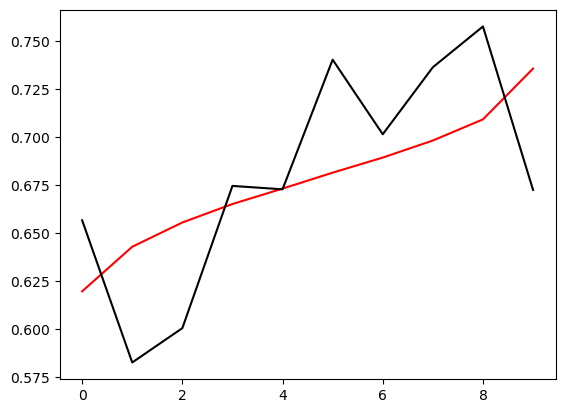

In [31]:
# Create figures
plt.plot(is_out_df['decile'], is_out_df['is_out_pred'], color='red')
plt.plot(is_out_df['decile'], is_out_df['is_out'], color='black')
plt.show() 

### Outs

In [32]:
%%time
# Neural network layers
layers = (30,30,30)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 15

outs_filename = f"model_outs_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(outs_filename)

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=1, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=2, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=3, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
model_outs = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(outs_dataset_train[pa_inputs2], outs_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_outs, open(os.path.join(model_path, outs_filename), 'wb'))

model_outs_relu_303030_15_20231104.sav
CPU times: total: 3.02 s
Wall time: 3min 4s


In [33]:
# Predict out types
outs_outputs = list(model_outs.classes_)
outs_outputs_pred = [x + "_pred" for x in outs_outputs]

proba = model_outs.predict_proba(outs_dataset_test[pa_inputs2])
for i, col in enumerate(outs_outputs_pred):
    outs_dataset_test[f'{col}'] = proba[:, i]

In [34]:
# Create deciles
for var in outs_outputs:
    outs_dataset_test[f'{var}_act'] = (outs_dataset_test['eventsModel'] == var).astype('int')
    outs_dataset_test['decile'] = pd.qcut(outs_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    globals()[df_name] = outs_dataset_test.query('imp_b == 1').query('imp_p == 1').groupby('decile').mean().reset_index()

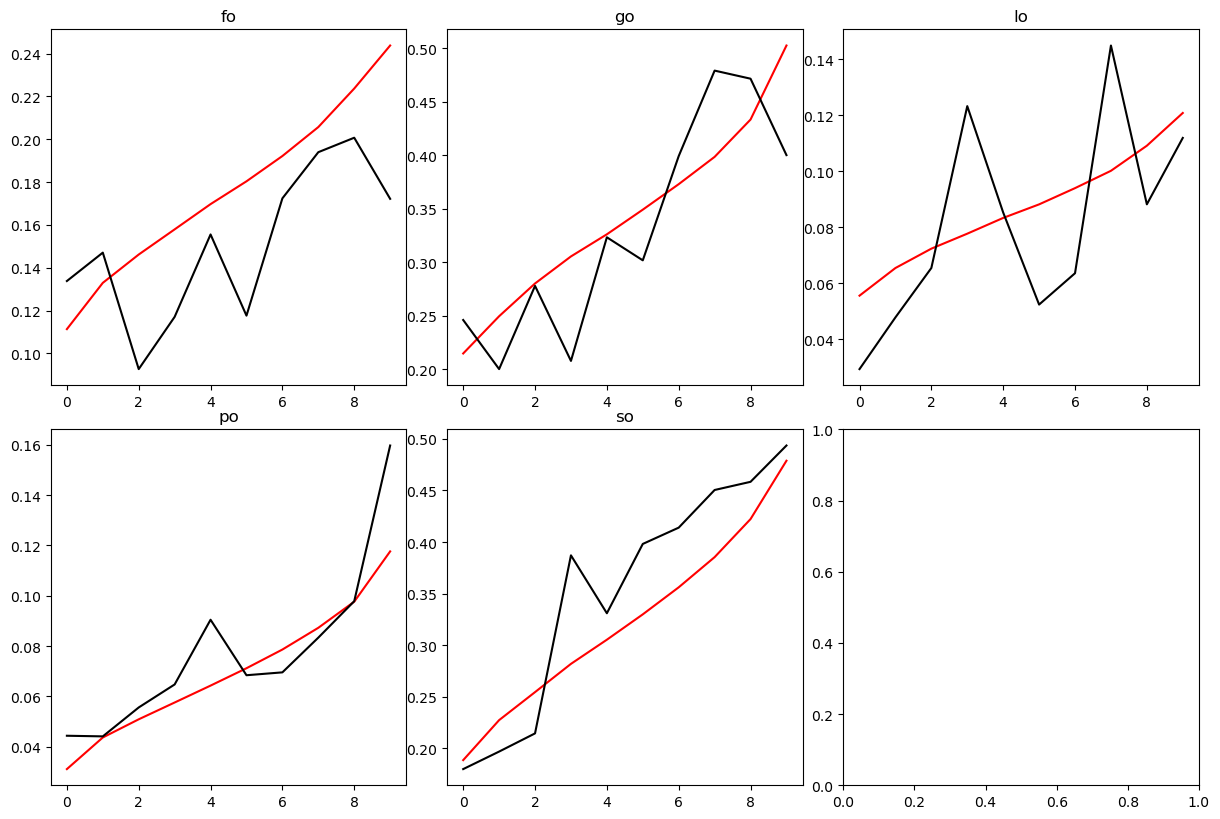

In [35]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(outs_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    df_name = var + "_df"
    axs[row, col].plot(globals()[df_name]['decile'], globals()[df_name][f'{var}_pred'], color='red')
    axs[row, col].plot(globals()[df_name]['decile'], globals()[df_name][f'{var}_act'], color='black')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(0,0.35)


# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

### Safe

In [36]:
%%time
# Neural network layers
layers = (30,30,30,30,30)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 30

safe_filename = f"model_safe_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(safe_filename)

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=1, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=2, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=3, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
model_safe = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(safe_dataset_train[pa_inputs2], safe_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_safe, open(os.path.join(model_path, safe_filename), 'wb'))

model_safe_relu_3030303030_30_20231104.sav
CPU times: total: 906 ms
Wall time: 3min 15s


In [37]:
# Predict safe types
safe_outputs = list(model_safe.classes_)
safe_outputs_pred = [x + "_pred" for x in safe_outputs]

proba = model_safe.predict_proba(safe_dataset_test[pa_inputs2])
for i, col in enumerate(safe_outputs_pred):
    safe_dataset_test[f'{col}'] = proba[:, i]

In [38]:
# Create deciles
for var in safe_outputs:
    safe_dataset_test[f'{var}_act'] = (safe_dataset_test['eventsModel'] == var).astype('int')
    safe_dataset_test['decile'] = pd.qcut(safe_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    globals()[df_name] = safe_dataset_test.query('imp_b == 0').query('imp_p == 0').groupby('decile').mean().reset_index()

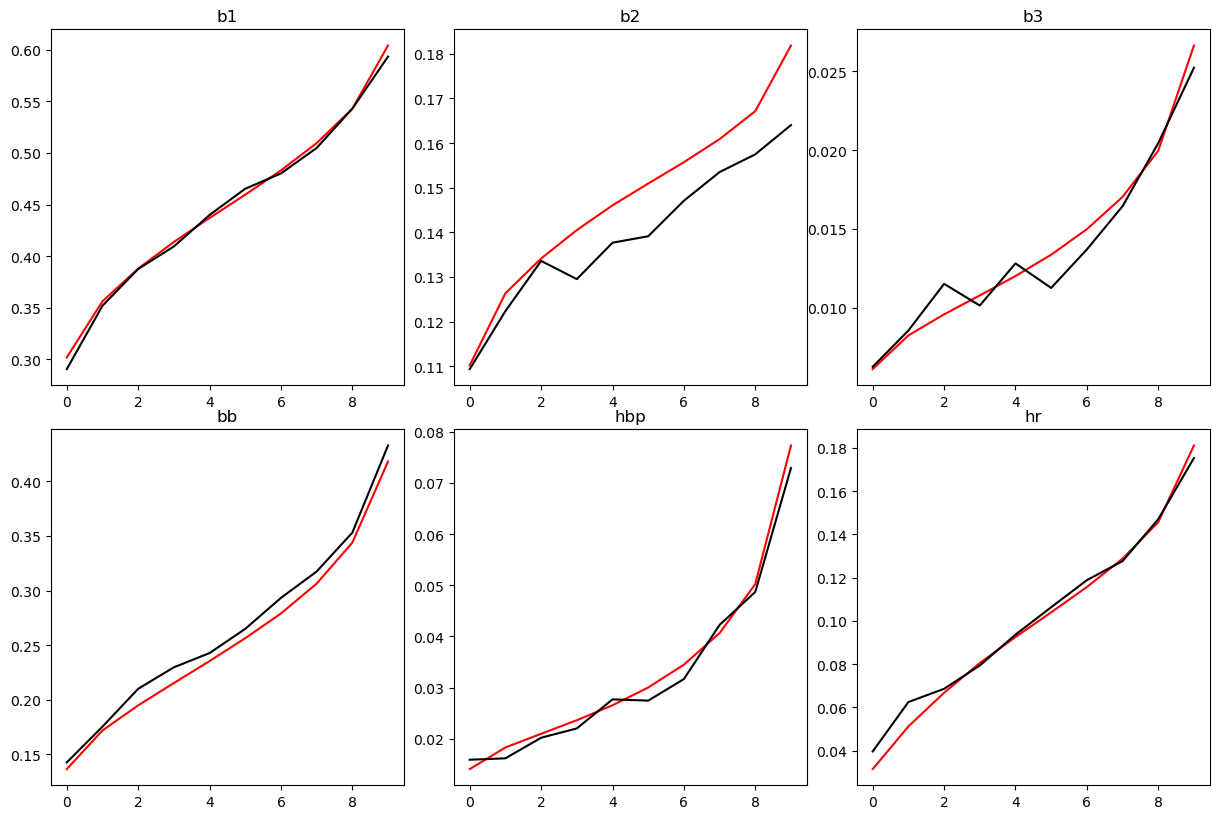

In [39]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(safe_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    df_name = var + "_df"
    axs[row, col].plot(globals()[df_name]['decile'], globals()[df_name][f'{var}_pred'], color='red')
    axs[row, col].plot(globals()[df_name]['decile'], globals()[df_name][f'{var}_act'], color='black')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(globals()[df_name][f'{var}_act'].min(),globals()[df_name][f'{var}_act'].max())


# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()